# Spectral Partitioning of Bipartite Graphs

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a _term $\times$ document_  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits__: The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: #1 "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

## Definitions

__Undirected bipartite graph__ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is __weighted__ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A __term-by-document-matrix__ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is 
$W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix},$$
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum\limits_{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum\limits_{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}.
$$

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

5. __Bipartitioning algorithm__ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
    the second largest singular value, $\sigma_2(A_n)$.
    3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
    $u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
    $\{(T_1,D_1),(T_2,D_2)\}$.


6. __Recursive bipartitioning algorithm__ is the following:
    1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
    $(T,D)$. Set the counter $c=2$.
    2. While $c<k$ repeat
         1. compute bipartitions of each of the subpartitions of $(T,D)$,
         2. among all $(c+1)$-subpartitions, choose the one with the smallest 
         $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
    3. Set $c=c+1$
    3. Stop

7. __Multipartitioning algorithm__ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
    $v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
    $\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
    3. Partition the rows of matrices 
    $\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
    and 
    $\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
    with the k-means algorithm.

### Example - Small term-by- document matrix

In [1]:
# Some packages
using LightGraphs
using GraphPlot
using Clustering

In [2]:
# Some functions
function my_weight_matrix(src::Array,dst::Array,weights::Array)
    n=nv(G)
    sparse([src;dst],[dst;src],[weights;weights],n,n)
end

my_laplacian(W::AbstractMatrix)=sparse(diagm(vec(sum(W,2))))-W

function my_normalized_laplacian(L::AbstractMatrix)
    D=1.0./sqrt.(diag(L))
    n=length(D)
    [L[i,j]*(D[i]*D[j]) for i=1:n, j=1:n]
end

my_normalized_laplacian (generic function with 1 method)

In [3]:
# Sources, targets, and weights
n=7
dn=[6,6,7,6,7,7]
tn=[1,2,2,3,4,5]
wn=[3,1,3,2,2,3]
[dn tn wn]

6×3 Array{Int64,2}:
 6  1  3
 6  2  1
 7  2  3
 6  3  2
 7  4  2
 7  5  3

In [4]:
mynames=["Term 1";"Term 2";"Term 3";"Term 4";"Term 5";"Doc 1";"Doc 2"]

7-element Array{String,1}:
 "Term 1"
 "Term 2"
 "Term 3"
 "Term 4"
 "Term 5"
 "Doc 1" 
 "Doc 2" 

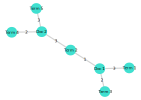

In [5]:
G=Graph(n)
for i=1:length(dn)
    add_edge!(G,tn[i],dn[i])
end
gplot(G, nodelabel=mynames, edgelabel=wn)

In [6]:
W=my_weight_matrix(tn,dn,wn)

7×7 SparseMatrixCSC{Int64,Int64} with 12 stored entries:
  [6, 1]  =  3
  [6, 2]  =  1
  [7, 2]  =  3
  [6, 3]  =  2
  [7, 4]  =  2
  [7, 5]  =  3
  [1, 6]  =  3
  [2, 6]  =  1
  [3, 6]  =  2
  [2, 7]  =  3
  [4, 7]  =  2
  [5, 7]  =  3

In [7]:
full(W)

7×7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [8]:
L=my_laplacian(W)
full(L)

7×7 Array{Int64,2}:
  3   0   0   0   0  -3   0
  0   4   0   0   0  -1  -3
  0   0   2   0   0  -2   0
  0   0   0   2   0   0  -2
  0   0   0   0   3   0  -3
 -3  -1  -2   0   0   6   0
  0  -3   0  -2  -3   0   8

In [9]:
Ln=my_normalized_laplacian(L)

7×7 Array{Float64,2}:
  1.0        0.0        0.0       0.0   0.0       -0.707107   0.0     
  0.0        1.0        0.0       0.0   0.0       -0.204124  -0.53033 
  0.0        0.0        1.0       0.0   0.0       -0.57735    0.0     
  0.0        0.0        0.0       1.0   0.0        0.0       -0.5     
  0.0        0.0        0.0       0.0   1.0        0.0       -0.612372
 -0.707107  -0.204124  -0.57735   0.0   0.0        1.0        0.0     
  0.0       -0.53033    0.0      -0.5  -0.612372   0.0        1.0     

In [10]:
A=W[1:5,6:7]
Δ₁=sqrt.(sum(A,2))
Δ₂=sqrt.(sum(A,1))
An=[A[i,j]/(Δ₁[i]*Δ₂[j]) for i=1:size(A,1), j=1:size(A,2)]

5×2 Array{Float64,2}:
 0.707107  0.0     
 0.204124  0.53033 
 0.57735   0.0     
 0.0       0.5     
 0.0       0.612372

In [11]:
# The partitioning - explain the results!
U,σ,V=svd(An)

([-0.46291 0.604743; -0.534522 -0.218218; … ; -0.377964 -0.370328; -0.46291 -0.453557], [1.0, 0.883883], [-0.654654 0.755929; -0.755929 -0.654654])

In [12]:
U[:,2]

5-element Array{Float64,1}:
  0.604743
 -0.218218
  0.493771
 -0.370328
 -0.453557

In [13]:
V[:,2]

2-element Array{Float64,1}:
  0.755929
 -0.654654

### Example - Sets of points

In [14]:
using Gadfly
using Images

In [15]:
?sprand;

search: sprand sprandn StepRange StepRangeLen spectral_distance



In [16]:
# Define sizes
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array{Any}(3)
s=srand(421)
for i=1:3
    A[i]=sprand(m[i],n[i],density[i])
end
B=blkdiag(A[1],A[2],A[3])

400×400 SparseMatrixCSC{Float64,Int64} with 28016 stored entries:
  [4  ,   1]  =  0.0793511
  [6  ,   1]  =  0.140307
  [9  ,   1]  =  0.298078
  [13 ,   1]  =  0.982495
  [20 ,   1]  =  0.0537056
  [23 ,   1]  =  0.977629
  [25 ,   1]  =  0.432631
  [27 ,   1]  =  0.954235
  [29 ,   1]  =  0.330135
  [31 ,   1]  =  0.246655
  ⋮
  [382, 400]  =  0.439011
  [385, 400]  =  0.112492
  [387, 400]  =  0.287446
  [388, 400]  =  0.300438
  [390, 400]  =  0.907918
  [392, 400]  =  0.782529
  [393, 400]  =  0.587851
  [394, 400]  =  0.568105
  [395, 400]  =  0.568407
  [398, 400]  =  0.923563
  [399, 400]  =  0.276277

In [17]:
pB=spy(B)
draw(Gadfly.PNG("files/pB.png", 4inch, 4inch), pB)

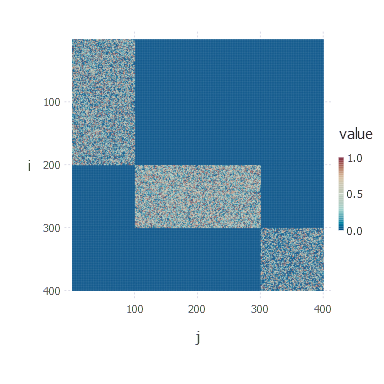

In [18]:
load("files/pB.png")

In [19]:
# The structure of singular vectors reflects the blocks
S,rest=svds(B,nsv=3)

(Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}([-3.78886e-17 -0.0612099 1.7273e-17; -5.43959e-17 -0.0690123 1.76575e-17; … ; -5.60077e-18 2.70445e-17 0.105727; -2.46455e-17 4.13055e-18 0.104], [50.0873, 36.1121, 20.3167], [-5.0975e-17 -1.03582e-16 … -1.3033e-17 1.11833e-17; -0.10022 -0.105289 … 8.68074e-18 3.04516e-18; -5.1983e-17 9.17582e-18 … 0.0863059 0.100151]), 6, 2, 34, [0.0524818, -0.144261, 0.063278, 0.138429, -0.116639, 0.0301536, -0.108042, 0.0648807, -0.100383, 0.0538196  …  0.0201516, 0.224082, 0.0662853, 0.0940261, 0.000254292, 0.218888, -0.175795, -0.00491862, -0.0662303, 0.0193381])

In [20]:
# S is a structure
fieldnames(S)

3-element Array{Symbol,1}:
 :U 
 :S 
 :Vt

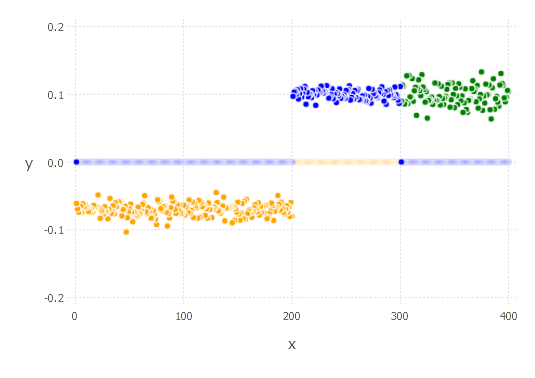

In [21]:
# Plot the first three left singular vectors
k=size(B,1)
x=collect(1:k)
Gadfly.plot(layer(x=x,y=S.U[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=S.U[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=S.U[:,3], Geom.point,Theme(default_color=colorant"green")))

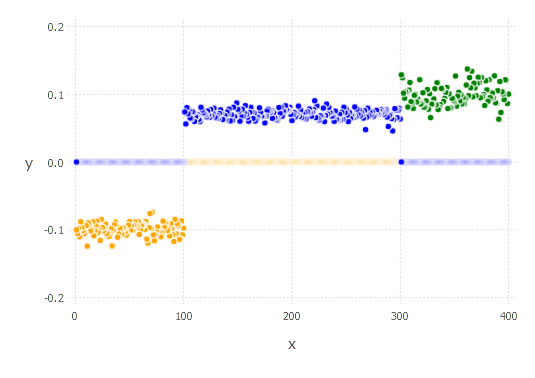

In [22]:
# Plot the first three right singular vectors
Gadfly.plot(layer(x=x,y=S.Vt[1,:],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=S.Vt[2,:], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=S.Vt[3,:], Geom.point,Theme(default_color=colorant"green")))

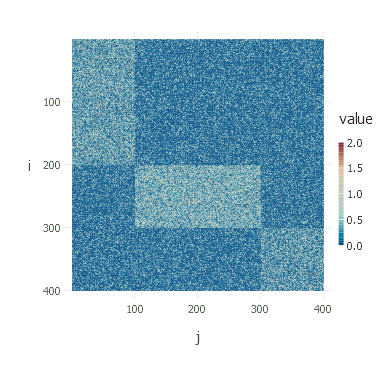

In [23]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
pC=spy(C)
draw(Gadfly.PNG("files/pC.png", 4inch, 4inch), pC)
load("files/pC.png")

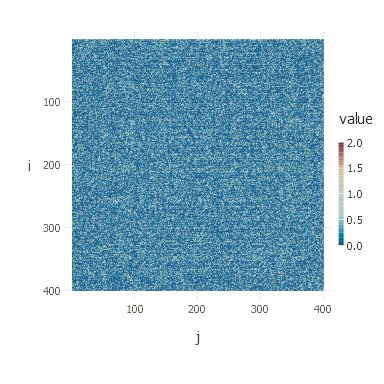

In [24]:
# Apply random permutation to rows and columns of C
D=C[randperm(k),randperm(k)]
pD=spy(D)
draw(Gadfly.PNG("files/pD.png", 4inch, 4inch), pD)
load("files/pD.png")

In [25]:
# Given D, can we recover C (with spectral partitioning)?
S,rest=svds(D,nsv=3)

(Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}([-0.0651511 -0.0643788 -0.00822275; -0.0738209 -0.077896 -0.0278001; … ; -0.040315 0.0121501 0.0703679; -0.0665022 -0.0670822 -0.0177929], [99.6158, 42.7096, 25.2006], [-0.039078 -0.0367447 … -0.0560793 -0.0365597; 0.0238933 0.0313994 … -0.0221926 0.02858; 0.107294 0.106008 … 0.00101403 0.0721089]), 6, 3, 42, [-0.148189, 0.363622, 0.298187, -0.322008, 0.111679, -0.0108851, -0.00470373, -0.391339, -0.00448173, 0.0839466  …  -0.187299, 0.243173, -0.178487, -0.134622, 0.227008, 0.0624095, -0.0861297, -0.131773, -0.133808, -0.0277195])

In [26]:
# K-means on rows of U 
outU=kmeans((S.U)',3)

Clustering.KmeansResult{Float64}([-0.0688622 -0.0377666 -0.0435021; -0.0694819 0.0151233 0.0482478; -0.0162362 0.0880518 -0.0251794], [1, 1, 3, 3, 1, 3, 3, 3, 3, 2  …  2, 2, 3, 2, 3, 1, 2, 2, 2, 1], [0.000104029, 0.00022911, 2.82118e-5, 0.000393815, 0.00186237, 0.000179088, 3.58036e-5, 7.62425e-5, 0.000195185, 0.000289477  …  7.80391e-5, 0.000594348, 4.97394e-6, 0.000267273, 0.000439693, 0.000192355, 0.000526239, 3.85509e-5, 0.000328055, 1.37517e-5], [100, 100, 200], [100.0, 100.0, 200.0], 0.1049918577064364, 2, true)

In [27]:
# K-means on Vt
outV=kmeans(S.Vt,3)

Clustering.KmeansResult{Float64}([-0.0518106 -0.0541609 -0.0374349; 0.0740591 -0.043118 0.0227095; -0.0394325 -0.0109275 0.0862321], [3, 3, 2, 2, 2, 3, 2, 2, 1, 2  …  1, 1, 1, 2, 2, 1, 2, 1, 2, 3], [0.000447716, 0.000467083, 0.000341363, 0.000613121, 0.000831481, 0.000696259, 0.000176135, 6.33959e-5, 3.76115e-5, 0.000740639  …  0.000212655, 0.000145948, 0.000575459, 0.000508112, 9.24982e-6, 0.000495866, 0.000266834, 0.000163146, 0.00058415, 0.000234695], [100, 200, 100], [100.0, 200.0, 100.0], 0.10989771851876712, 2, true)

In [28]:
sortperm(outV.assignments)

400-element Array{Int64,1}:
   9
  13
  28
  29
  36
  39
  43
  45
  49
  50
  51
  52
  53
   ⋮
 339
 345
 361
 363
 365
 374
 381
 385
 386
 388
 390
 400

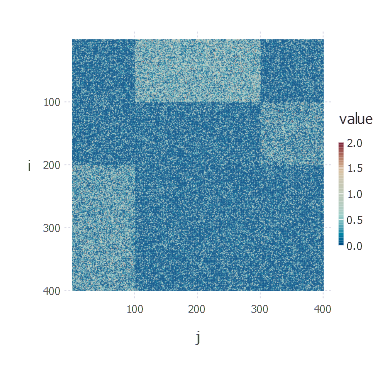

In [29]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
pE=spy(E)
draw(Gadfly.PNG("files/pE.png", 4inch, 4inch), pE)
load("files/pE.png")